In [39]:
import gensim.downloader as api
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize,word_tokenize
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import numpy as np


General Methods

In [40]:
def compute_max(model, target, word1, word2, word3, word4, answer):
    # Determines the cosine similarity between two embeddings and retrieves the closest one to the target (question-word)
    words = [word1, word2, word3,word4]
    max_similarity = -1  
    selected_word = None

    for word in words:
        try:
            similarity = model.similarity(word, target)
            if similarity > max_similarity:
                # Keep the word with the greatest similarity to the target word
                max_similarity = similarity
                selected_word = word
        except KeyError:
            print(f"KeyError: {word}")
            continue
    #A guess is when [word1,word2,word3] is none or question-word, or all words in [word1,word2,word3] are not in corpus
    if selected_word is None or target not in model.index_to_key or all(word not in model.index_to_key for word in words):
        label = 'guess'
    elif selected_word == answer:
        label = 'correct'
    else:
        label = 'wrong'

    return selected_word, label



def write_model_to_csv(name,model):
    # Writes a dataframe to a file demonstrating the best predicted synonym based on a question-word.
    # It also indicates whether the model correctly labeled the expected predicted word.

    df_synonym = pd.read_csv('synonym.csv')

    result_df = {
        'question' : [],
        'answer' : [],
        'predictions': [],
        'label': []
    }

    result_df['question'] = df_synonym['question']
    result_df['answer'] = df_synonym['answer']

    predictions = []
    labels = []
    
    for index in range(len(df_synonym)):
        prediction, label = compute_max(model, str(df_synonym['question'][index]), str(df_synonym['0'][index]),str(df_synonym['1'][index]), str(df_synonym['2'][index]),str(df_synonym['3'][index]),str(df_synonym['answer'][index]))
        predictions.append(prediction)
        
        labels.append(label)
    
    result_df['predictions'] = predictions
    result_df['label'] = labels
    pd.DataFrame(result_df).to_csv(f'{name}-details.csv', index=False)


def get_analysis(name, model):
    # Evaluates the model's performance 
    df_for_analysis = pd.read_csv(f'{name}-details.csv')

    label_counts = df_for_analysis['label'].value_counts()
    correct = label_counts.get('correct', 0)
    wrong = label_counts.get('wrong',0)
    guess = label_counts.get('guess', 0)
    v = correct + wrong
    line = f'{name}, {len(model.index_to_key)}, {correct}, {v}, {correct/v}'
    return line

def write_analysis(line):
    # Writes the model's performance to a csv file
    with open('analysis.csv', 'a+') as my_file:
        my_file.write(line + '\n')

def create_graph():
    #Plot the accuracy of each model
    df_for_graph = pd.read_csv('analysis.csv',header=None)

    model_names = df_for_graph[0]
    model_accuracies =  df_for_graph[4]

    student_predictions = 88.28
    baseline = 0.25

    names = df_for_graph[0]
    accuracy = df_for_graph[4]

    #plot data
    plt.xticks(rotation=45, ha='right')

    plt.bar(names, accuracy, color='lightgreen')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy Comparison')

    # Add lines at y = 0.88 and y = 0.25
    plt.axhline(y=0.88, color='red', linestyle='--', label='Student Accuracy')
    plt.axhline(y=0.25, color='black', linestyle='--', label='Human Baseline')
    plt.legend()

<span style="font-size:35px;"> Task 1: <span/>


In [16]:
# Load the model and read file as a dataframe, (we chose .csv format)
wv = api.load('word2vec-google-news-300')
df_synonym = pd.read_csv('synonym.csv')

In [42]:
def analysis_part_one():
    write_model_to_csv('word2vec-google-news-300',wv)
    line = get_analysis('word2vec-google-news-300',wv)
    write_analysis(line)
analysis_part_one()

<span style="font-size:35px;"> Task 2: <span/>


In [22]:
# Files of same size but different corpus
crawl_subwords_300 = api.load('fasttext-wiki-news-subwords-300')
wiki_giga_300 = api.load('glove-wiki-gigaword-300')

# Files from the same corpus but different size
twitter_50 = api.load('glove-twitter-50')
twitter_100 = api.load('glove-twitter-100')


In [43]:
def analysis_part_two():
    # Run complete analysis on all 4 models
    write_model_to_csv('twitter-50',twitter_50)
    string_output = get_analysis('twitter-50',twitter_50)
    write_analysis(f'{string_output}')

    write_model_to_csv('twitter-100',twitter_100)
    string_output = get_analysis('twitter-100',twitter_100)
    write_analysis(f'{string_output}')


    write_model_to_csv('crawl-subwords_300',crawl_subwords_300)
    string_output = get_analysis('crawl-subwords_300',crawl_subwords_300)
    write_analysis(f'{string_output}')

    write_model_to_csv('wiki-giga_300',wiki_giga_300)
    string_output = get_analysis('wiki-giga_300',wiki_giga_300)
    write_analysis(f'{string_output}')
analysis_part_two()

Graph Analysis

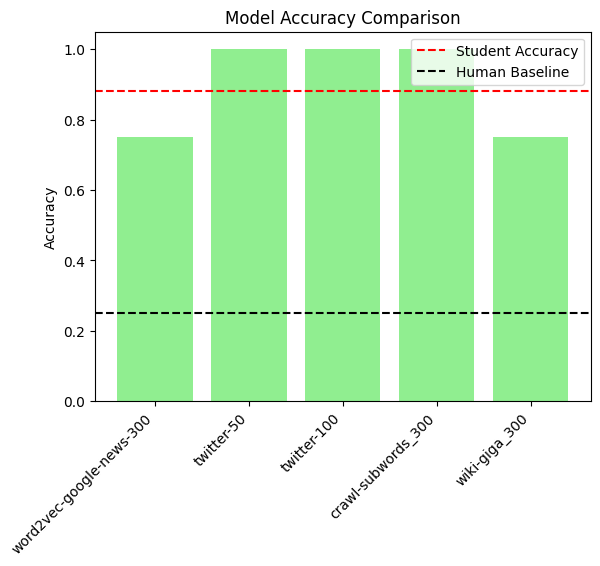

In [24]:
df_for_graph = pd.read_csv('analysis.csv',header=None)
df_for_graph.columns =['model_name','size','correct','guesses','accuracy']
df_for_graph.head()
create_graph()

<span style="font-size:35px;"> Task 3: <span/>


In [44]:
def part_three():

    books = []
    book_names = ['alice_in_wonderland.txt','frankenstein.txt','great_gatsby.txt','pride_and_prejudice.txt','scarlett_letter.txt']
    for book in book_names:
        #Read every book
        with open(f'books/{book}', 'r', encoding='utf-8') as file:
            try:
                text = file.read()
                sentences = sent_tokenize(text) #Convert book into sentences
                words = [word_tokenize(sentence) for sentence in sentences] #Convert sentences to words
                books.extend(words) # add only when no duplicates
            except:
                continue
    window_sizes = [50,100] #the number of words before and after
    embedding_sizes = [100, 300] # the number of hidden layer
   
    #Create 4 Models of varying window and embedding sizes
    corpus_size = 0
    for window_size in window_sizes:
        for embedding_size in embedding_sizes:
            model = Word2Vec(books, vector_size=embedding_size, window=window_size, min_count=1, workers=4)
            corpus_size = len(model.wv.key_to_index)
            model.save(f'model-{corpus_size}-{embedding_size}-{window_size}.model')
            
    return books,corpus_size

books,corpus_size = part_three()

In [46]:

def analysis_part_three(books,corpus_size):
    #Train all 4 models
    window_sizes = [50, 100] #the number of words before and after
    embedding_sizes = [100, 300] # the number of hidden layer
    for window_size in window_sizes:
        for embedding_size in embedding_sizes:
            loaded_model = Word2Vec.load(f'model-{corpus_size}-{embedding_size}-{window_size}.model')
            loaded_model.train(books,total_examples=len(books),epochs=2)

            write_model_to_csv(f'model-{corpus_size}-{embedding_size}-{window_size}-details.model',loaded_model.wv)
            string_output = get_analysis(f'model-{corpus_size}-{embedding_size}-{window_size}-details.model',loaded_model.wv)
            write_analysis(f'{string_output}')


analysis_part_three(books, corpus_size)

KeyError: exceptional
KeyError: disperse
KeyError: isolate
KeyError: accelerate
KeyError: exceptional
KeyError: disperse
KeyError: isolate
KeyError: accelerate
KeyError: exceptional
KeyError: disperse
KeyError: isolate
KeyError: accelerate
KeyError: exceptional
KeyError: disperse
KeyError: isolate
KeyError: accelerate


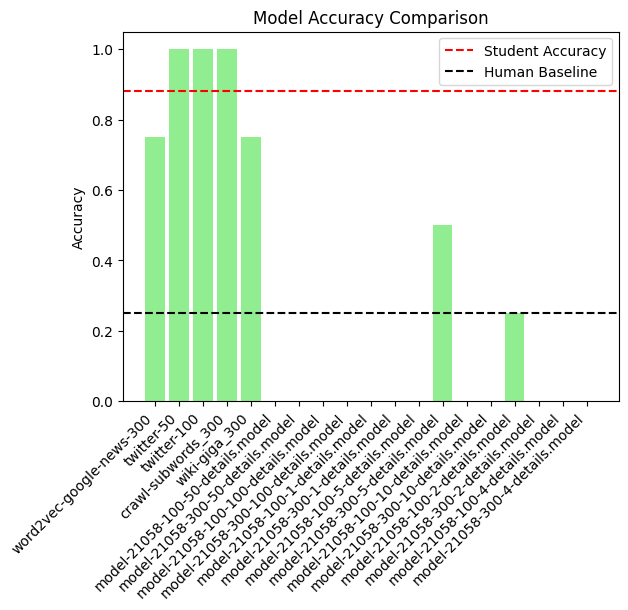

In [38]:
create_graph()